# Next word prediction using LSTM

- https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
- https://towardsdatascience.com/next-word-prediction-with-nlp-and-deep-learning-48b9fe0a17bf

In [1]:
import numpy as np
import pylab as plt

import json 
import pickle 

# NLP imports
import re
import nltk, gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

data_dir = '../nlp_datasets/'

In [139]:
def load_text_data():
    file = open(data_dir + 'Metamorphosis_Franz_Kafka.txt', 'r', encoding = "utf8")
    doc = ''
    for line in file.readlines():
        doc = doc + line
    return doc

def preprocess_text(raw_doc=None, return_raw_data=False):
    
    if raw_doc is None:
        print ("Loading the Full text.")
        raw_doc = load_text_data()
    
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;\n]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))

    doc = raw_doc.lower()
    doc = REPLACE_BY_SPACE_RE.sub(' ',doc)
    doc = BAD_SYMBOLS_RE.sub('', doc)
    doc = ' '.join([word for word in doc.split() if word not in STOPWORDS])
    
    # remove the different form of the same word
    doc = doc.split(' ')
    stemmer = PorterStemmer()
    doc = [stemmer.stem(d) for d in doc]
    
    if return_raw_data:
        return raw_doc, doc
    return doc

data = preprocess_text()

print (doc_words[:10])
    

Loading the Full text.
['project', 'gutenberg', 'ebook', 'metamorphosi', 'franz', 'kafka', 'translat', 'david', 'wylli', 'ebook']


In [122]:
raw_data = preprocess_text(return_raw_data=True)[0]
raw_data[:100]

Loading the Full text.


'\ufeffThe Project Gutenberg EBook of Metamorphosis, by Franz Kafka\nTranslated by David Wyllie.\n\nThis eBoo'

## Tokenize the data

In [123]:
tokenizer = Tokenizer(num_words=10000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\n', lower=True)
tokenizer.fit_on_texts(data)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 2252 unique tokens.


In [124]:
X = tokenizer.texts_to_sequences(data)
print ( X[:10] )

[[11], [51], [118], [439], [593], [594], [595], [506], [507], [118]]


**The most repeated words**

In [125]:
# Also check these out
# tokenizer.index_docs, tokenizer.index_word
# tokenizer.word_index, tokenizer.word_docs
word_counts = tokenizer.word_counts  # same as json.loads(config['word_counts'])
word_counts_sorted = sorted(word_counts.items(), key=lambda kv:kv[1], reverse=True)[:10]
print (f"Top 5 repeated words are:\n{word_counts_sorted}")

Top 5 repeated words are:
[('gregor', 298), ('would', 187), ('room', 133), ('could', 120), ('work', 114), ('even', 104), ('father', 102), ('sister', 101), ('door', 97), ('mother', 90)]


In [126]:
# Index for each words
#for item in list(json.loads(config['word_index']).items())[:5]:
#    print (item)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

2253


In [127]:
sequences = tokenizer.texts_to_sequences([data])[0]
sequences[:5]

[11, 51, 118, 439, 593]

In [129]:
print ("First 5 words:", data[:5])
for w in doc_words[:5]:
    print (f'(word, index): {w, tokenizer.word_index[w]}')

First 5 words: ['project', 'gutenberg', 'ebook', 'metamorphosi', 'franz']
(word, index): ('project', 11)
(word, index): ('gutenberg', 51)
(word, index): ('ebook', 118)
(word, index): ('metamorphosi', 439)
(word, index): ('franz', 593)


In [179]:
def prepare_sequence(doc, n_steps=16):
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts([doc])
    vocab_size = len(tokenizer.word_index) + 1
    sequences = tokenizer.texts_to_sequences([doc_words])[0]
    
    X, y = list(), list()
    for i in range(len(sequences)-n_steps-1):
        X.append(sequences[i:i+n_steps])#i+n_steps])
        y.append(sequences[i+n_steps])
    return (np.array(X), np.array(y), tokenizer, vocab_size)

n_steps = 5
(X, y, tokenizer, vocab_size ) = prepare_sequence(data, n_steps=n_steps)
#y = to_categorical(y, num_classes=vocab_size)
print ( X.shape, y.shape)

(11935, 5) (11935,)


In [180]:
# train-test split
from sklearn.model_selection import train_test_split

X_train_, X_test, y_train_, y_test = train_test_split(X, y, test_size=0.2, random_state=8848)
X_train,  X_val,  y_train , y_val = train_test_split(X_train_, y_train_,
                                                     test_size=0.25, random_state=8848)

print (f"X_train.shape: {X_train.shape} y_train.shape:{y_train.shape}" )
print (f"X_test.shape: {X_test.shape} y_test.shape:{y_test.shape}" )
print (f"X_val.shape: {X_val.shape} y_val.shape:{y_val.shape}" )

X_train.shape: (7161, 5) y_train.shape:(7161,)
X_test.shape: (2387, 5) y_test.shape:(2387,)
X_val.shape: (2387, 5) y_val.shape:(2387,)


## Model building

In [181]:
# convert y data to categorical data
y_train = to_categorical(y_train, num_classes=vocab_size)
y_test  = to_categorical(y_test,  num_classes=vocab_size)
y_val   = to_categorical(y_val,   num_classes=vocab_size)

print (f"X_train.shape: {X_train.shape} y_train.shape:{y_train.shape}" )
print (f"X_test.shape: {X_test.shape} y_test.shape:{y_test.shape}" )
print (f"X_val.shape: {X_val.shape} y_val.shape:{y_val.shape}" )

X_train.shape: (7161, 5) y_train.shape:(7161, 2254)
X_test.shape: (2387, 5) y_test.shape:(2387, 2254)
X_val.shape: (2387, 5) y_val.shape:(2387, 2254)


In [201]:
def make_model():
    embedding_dim = 10
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=n_steps))
    model.add(LSTM(32, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(vocab_size, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0001))
    return model

model = make_model()

In [202]:
#from tensorflow import keras
#from keras.utils.vis_utils import plot_model
#keras.utils.plot_model(model, show_layer_names=True)#, to_file='model_fig.png')

In [203]:
history=model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)#, callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/20
448/448 [==============================] - 2s 5ms/step - loss: 7.5661
Epoch 2/20
448/448 [==============================] - 2s 5ms/step - loss: 6.8488
Epoch 3/20
448/448 [==============================] - 2s 5ms/step - loss: 6.7803
Epoch 4/20
448/448 [==============================] - 2s 5ms/step - loss: 6.7546
Epoch 5/20
448/448 [==============================] - 2s 5ms/step - loss: 6.7312
Epoch 6/20
448/448 [==============================] - 3s 6ms/step - loss: 6.7078
Epoch 7/20
448/448 [==============================] - 2s 5ms/step - loss: 6.6864
Epoch 8/20
448/448 [==============================] - 2s 5ms/step - loss: 6.6675
Epoch 9/20
448/448 [==============================] - 2s 5ms/step - loss: 6.6516
Epoch 10/20
448/448 [==============================] - 2s 5ms/step - loss: 6.6378
Epoch 11/20
448/448 [==============================] - 2s 5ms/step - loss: 6.6260
Epoch 12/20
448/448 [==============================] - 2s 5ms/step - loss: 6.6150
Epoch 13/20
448/448 [====

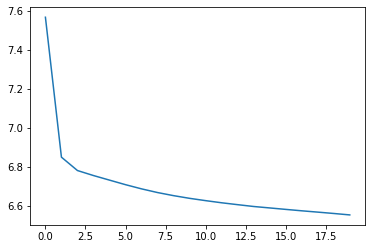

In [204]:
plt.plot(history.history['loss'])

In [205]:
# save model and the tokenizer
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))
model.save_weights("model.h5")

## Predictions

In [206]:
X_train[1]

array([ 56, 675, 277, 366,  42])

In [207]:
#text = "They were going for a wonderful vacation as well as shopping"
#text = "Eventually, though, Gregor realised that he had no"
text = "Did you understand a word of all that the chief clerk asked his"
text = preprocess_text(text)

#seq = np.array(tokenizer.texts_to_sequences(text))
#preds = model.predict_classes(seq)

In [208]:
seq = np.array(tokenizer.texts_to_sequences(text))[-1]
preds = model.predict_classes(seq)
pred_words = tokenizer.index_word[preds[0]]
print (pred_words)

could


In [178]:
text = "collection of textile"
text = "of textile collection"
text = "at the dull"
text = "what a strenuous"
text =preprocess_text(text)
seq = np.array(tokenizer.texts_to_sequences(text))[-1]
preds = model.predict_classes(seq)
pred_words = tokenizer.index_word[preds[0]]
print (pred_words)

gregor
